In [1]:
from numpy.random import Generator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy
from scipy.optimize import minimize 

In [2]:
config = {
    'nbase': 100,
    'neca': 1000,
}

In [3]:
def plot_dist(data1, data2, ax=None):
    if not ax:
        _, ax = plt.subplots(1,1)
        
    ax.hist(data1['age'], density=True, fill=False, histtype='stepfilled', 
             edgecolor='black', linewidth=1.2, label=data1.name)
    ax.hist(data2['age'], density=True, fill=False, histtype='stepfilled',
             edgecolor='blue', linewidth=1.2, label=data2.name)
    ax.legend()
    return 

In [4]:
# For Base cohort
age = 45

mean = [age]
cov = [[14]]

x = np.random.default_rng().multivariate_normal(mean, cov, config['nbase'])
x[x< 0] = 0
data_base = pd.DataFrame(x, columns=['age'])

In [5]:
# For External cohort
age = 55

mean = [age]
cov = [[20]]
x = np.random.default_rng().multivariate_normal(mean, cov, config['neca'])
x[x< 0] = 0
data_eca = pd.DataFrame(x, columns=['age'])

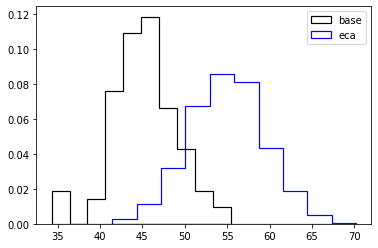

In [6]:
data_base.name = 'base'
data_eca.name = 'eca'
plot_dist(data_base, data_eca)

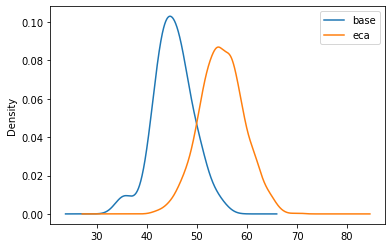

In [9]:
for i, col in enumerate(data_base.columns):
    plt.figure()
    data_base['age'].plot.kde(label='base')
    data_eca['age'].plot.kde(label='eca')
    plt.legend()

In [10]:
density_age = scipy.stats.gaussian_kde(data_base['age'])
max_age, min_age = data_base['age'].max(), data_base['age'].min()

In [11]:
b = max(data_base['age'].max(), data_eca['age'].max())
a = min(data_base['age'].min(), data_eca['age'].min())
waypoints = np.linspace(a, b, 100)

In [12]:
def calc_loss(w):    
    est_den_age = scipy.stats.gaussian_kde(data_eca['age'], weights=w)
    
    loss = (density_age(waypoints)- est_den_age(waypoints))**2
    
    return sum(loss)

In [13]:
def noneg(x):
    return x - 0.00001

cons = ({'type': 'ineq', 'fun': noneg},
        {'type': 'eq', 'fun': lambda x: sum(x) - 1})

In [14]:
%%time
weights = 0.001*np.ones(config['neca'])

wopt = minimize(calc_loss, weights, constraints=cons, options= 
            {"disp":True,"maxiter":1000})
p = wopt.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0006203147495176396
            Iterations: 20
            Function evaluations: 20027
            Gradient evaluations: 20
CPU times: user 1min 18s, sys: 260 ms, total: 1min 18s
Wall time: 1min 19s


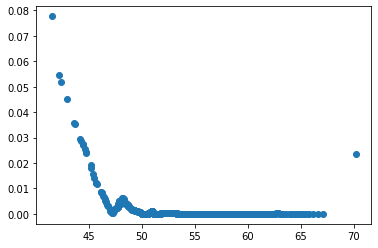

In [21]:
plt.scatter(data_eca['age'], p)

In [15]:
data_eca_study = data_eca.sample(n=config['nbase'], replace=True, weights=p)

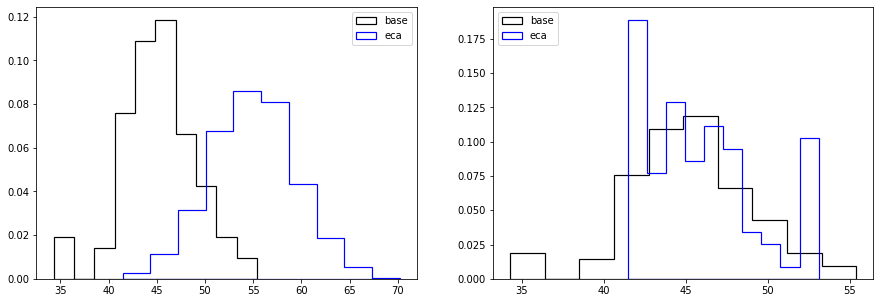

In [16]:
_, ax = plt.subplots(1,2, figsize=(15, 5))

data_base.name = 'base'
data_eca_study.name = 'eca'
plot_dist(data_base, data_eca, ax[0])

data_base.name = 'base'
data_eca_study.name = 'eca'
plot_dist(data_base, data_eca_study, ax[1])